# Statistika: Výsledky zkoušek

>[Data byla získana z webu kaggle](https://www.kaggle.com/datasets/spscientist/students-performance-in-exams?select=StudentsPerformance.csv)


In [54]:
import sys
#!{sys.executable} -m pip install statsmodels
import numpy
import pandas as pd  
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Načtení dat

In [55]:
table = pd.read_csv('./StudentsPerformance.csv', delimiter=',')
table.head()


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


# 1. test

Prozkouáme, zda reading score je dobře modelováno normálním rozdělením.

To uděláme pomocí chi-kvadrát testu.

Nulová hypotéza: reading score je dobře modelováno normálním rozdělením.<br>
Alternativní hypotéza: data nejsou dobře modelována normálním rozdělením.

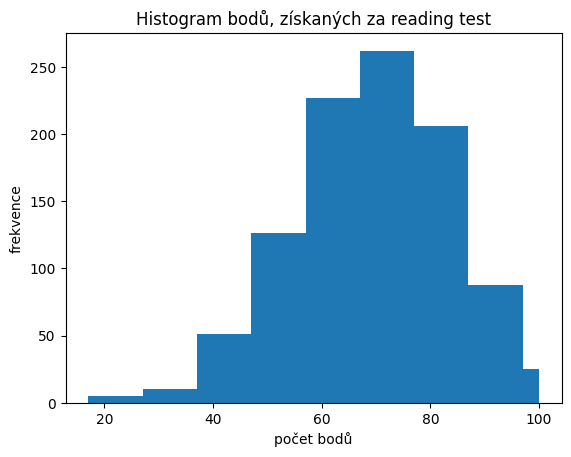

In [71]:
reading_score = table['reading score']
figure, main_ax = plt.subplots()
main_ax.set_title('Histogram bodů, získaných za reading test')
main_ax.set_xlabel('počet bodů')
main_ax.set_ylabel('frekvence')
plt.hist(reading_score, bins=[17, 27, 37, 47, 57, 67, 77, 87, 97, 100])
plt.show()


Histogram vypadá dobře, takže pojďme určit průměr, rozptyl a směrodatnou odchylku.

In [57]:
reading_score_mean = reading_score.mean()
print(f"Průměr = {reading_score_mean}")
reading_score_var = reading_score.var()
print(f"Rozptyl = {reading_score_var}")
reading_score_std = numpy.std(reading_score)
print(f"Směrodatná odchylka = {reading_score_std}")

Průměr = 69.169
Rozptyl = 213.16560460460462
Směrodatná odchylka = 14.592890015346516


Dále vytvoříme intervály a spočteme, kolik studentů připadá na každý interval.

Intervaly: < 20, < 40, < 60, < 80, 80 >=.


In [58]:
intervals = [20, 40, 60, 80]
numbers_in_intervals = [0, 0, 0, 0, 0]
numbers_in_intervals[0] = sum(reading_score < intervals[0])
numbers_in_intervals[len(intervals)] = sum(reading_score >= intervals[len(intervals)-1])
for i in range(1, len(intervals)):
    numbers_in_intervals[i] = sum(reading_score < intervals[i]) - sum(reading_score<intervals[i-1])

print(f"Počet studentů v každém intervalu: {numbers_in_intervals}")

Počet studentů v každém intervalu: [1, 25, 228, 497, 249]


Teď najdeme z-skóre. Z-skóre spočteme jako podíl rozdílu horní hranice intervalu a průměru a směrodatné odchylky.

In [72]:
z_score = [0, 0, 0, 0, 0]
for i in range(len(intervals)):
    z_score[i] = (intervals[i]-reading_score_mean)/reading_score_std


print(f"Z-skóre pro každý interval: : {z_score}")

Z-skóre pro každý interval: : [-3.3693805646648296, -1.9988501228560356, -0.6283196810472415, 0.7422107607615527, 0]


Ze z-skóre spočteme plochu pod křívkou normálního rozdělení N(0, 1):

In [73]:
area_under_curve = [0, 0, 0, 0, 0]

for i in range(len(area_under_curve)):
    area_under_curve[i] = stats.norm.cdf(z_score[i])

area_under_curve[len(area_under_curve)-1] = 1
print(f"Plocha pod křívkou: {area_under_curve}")

Plocha pod křívkou: [0.00037668666427077846, 0.02281228635540259, 0.2648972706508279, 0.771020175075132, 1]


Dále najdeme plochu pod křívkou v jednotlivých intervalech.

In [61]:
area_in_intervals = [0, 0, 0, 0, 0]
area_in_intervals[0] = round(area_under_curve[0], 5)

for i in range(1, len(area_in_intervals)):
    area_in_intervals[i] = round(area_under_curve[i]- area_under_curve[i-1], 5) 

print(f"Plochu pod křívkou v jednotlivých intervalech: {area_in_intervals}")

Plochu pod křívkou v jednotlivých intervalech: [0.00038, 0.02244, 0.24208, 0.50612, 0.22898]


Plochu v jednotlivých intervalech využijeme jako očekávané pravděpodobnosti pro chi-kvadrát test. 

Provedeme normalizaci dat pro chi-kvadrát test. Potřebujeme, aby se součty očekavaných dat <em>( pravděpodobnost (`area_in_intervals`) krát počet studentů (`number_of_students`))</em> a pozorovaných dat <em>(`numbers_in_intervals`)</em> rovnaly.

In [62]:
number_of_students = sum(numbers_in_intervals)

for i in range(len(area_in_intervals)):
    area_in_intervals[i] = area_in_intervals[i]*number_of_students

stats.chisquare(numbers_in_intervals, f_exp=area_in_intervals)

Power_divergenceResult(statistic=4.037268407465405, pvalue=0.4009856150302119)

# Závěr

P-hodnota je větší než 0.05 (hladina významnosti testu), takže nulovou hypotézu nezamítneme. Reading score je dobře modelováno normálním rozdělením.

# 2. test

Ve druhém testu budeme zkoumat závislost mezi reading score a writing score. Předpokladáme, že čím větší je reading score, tím větší je writing score. Provedeme lineární regresi.

Nulová hypotéza: mezi reading score a writing score ne existuje lineární závislost.<br>
Alternativní hypotéza: mezi reading score a writing score existuje lineární závislost.

### Načteme data a přeformujeme je.

In [89]:
reading_score = table['reading score']
writing_score = table['writing score']

x = reading_score.values.reshape(-1, 1)
y = writing_score.values.reshape(-1, 1)

<class 'numpy.ndarray'>


### Zobrazíme data.

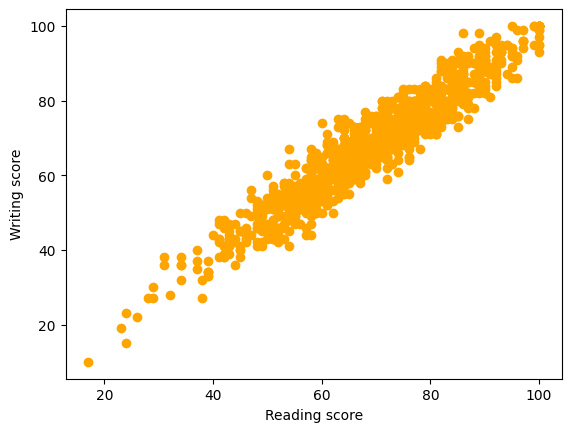

In [64]:
figure, axis = plt.subplots()
axis.set_ylabel('Writing score')
axis.set_xlabel('Reading score')

plt.scatter(x, y, color="orange")
plt.show()

Dál spočteme průměr writing score a reading score.

In [65]:
reading_score_mean = reading_score.mean()
print(f'Průměr reading score = {reading_score_mean}')
writing_score_mean = writing_score.mean()
print(f'Průměr writing score = {writing_score_mean }')

Průměr reading score = 69.169
Průměr writing score = 68.054


Určíme přímku. Přímka a nutné formule jsou popsány [tady](https://iuuk.mff.cuni.cz/~samal/vyuka/2223/PSt1/slides-13.pdf).

In [66]:
reading_score_sum = 0
v0 = 0
v1 = 0

for i in range(len(writing_score)):
    v1 += (reading_score[i] - reading_score_mean)*(writing_score[i] - writing_score_mean)
    reading_score_sum += (reading_score[i] - reading_score_mean)**2

v1 = v1/reading_score_sum
v0 = writing_score_mean - v1*reading_score_mean

print("The linear model is: Y = {:.5} + {:.5} * X".format(v0, v1))

The linear model is: Y = -0.66755 + 0.99353 * X


Dál zobrazíme přímku na grafu.

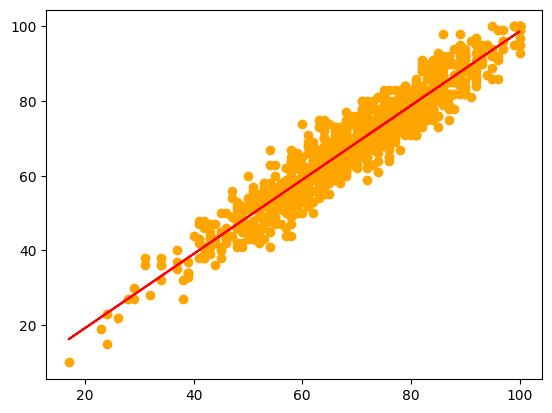

In [67]:
plt.scatter(x, y, color="orange")
plt.plot(x, v1*x+v0, c="red")
plt.show()

Teď určíme p-hodnotu. Reading_score_sum bude konstantou, s ní provedeme OLS regresi. Postup byl získán [zde](https://www.statology.org/statsmodels-linear-regression-p-value/) a částečně [zde]((https://towardsdatascience.com/the-complete-guide-to-linear-regression-in-python-3d3f8f06bf8)).

In [68]:
X = sm.add_constant(x)
model = sm.OLS(y, X).fit()

print(model.summary())
print(f"P-hodnota je {model.pvalues[1]}")


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                 1.025e+04
Date:                Fri, 28 Jul 2023   Prob (F-statistic):               0.00
Time:                        18:27:35   Log-Likelihood:                -2928.4
No. Observations:                1000   AIC:                             5861.
Df Residuals:                     998   BIC:                             5871.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6676      0.694     -0.962      0.3

# Závěr: 
P-hodnota je menší než 0.05 (hladina významnosti testu), takže musíme zamítnout nulovou hypotézu. Z toho vyplývá, že mezi reading score a writing score existuje lineární závislost.

# 3. test

Ve 3. testu prozkoumáme, jestli se střední hodnota math score studentů, kteří absolvovali kurz po přípravě k testu, líší od střední hodnoty math score studentů, kteří ten kurz neabsolvovali. Použijeme dvouvýběrový test.

Nulová hypotéza: střední hodnoty math score studentů ze dvou skupin se neliší.<br>
Alternativní hypotéza: střední hodnoty se liší. 

Připravíme data:

In [69]:
course_complete = []
course_not_complete = []
math_score = table["math score"]
course_info = table["test preparation course"]


for i in range(len(math_score)):
    if course_info[i] == "completed":
        course_complete.append(math_score[i])
    else:
        course_not_complete.append(math_score[i])


Teď provedeme ttest z knihovny scipy.stats.

In [70]:
result = stats.ttest_ind(course_complete, course_not_complete, equal_var=False, alternative='two-sided')
print(result)

print(f"\nStřední hodnota math score studentů, kteří absolvovali kurz: {sum(course_complete)/len(course_complete)}")
print(f"Střední hodnota math score studentů, kteří neabsolvovali kurz: {sum(course_not_complete)/len(course_not_complete)}")

Ttest_indResult(statistic=5.786983157907755, pvalue=1.0425616722069513e-08)

Střední hodnota math score studentů, kteří absolvovali kurz: 69.69553072625699
Střední hodnota math score studentů, kteří neabsolvovali kurz: 64.0778816199377


# Závěr:

P-hodnota je menší než 0.05 (hladina významnosti testu), takže zamítneme nulovou hypotézu, z čehož vyplývá, že střední hodnoty math score dvou skupin studentů liší.

Pod p-hodnotou jsou vypsány střední hodnoty těchto dvou skupin, abychom ověřili, jak se liší. Je vidět, že studenti, kteří absolvovali kurz, měli větší úspěch u matematického testu.

# 4. test

Ve 4. testu prozkoumáme, jestli pohlaví studenta mí á vliv na math score studenta. Provedeme to pomocí dvouvýběrového testu.

Nulová hypotéza: pohlaví studenta nemá vliv na výsledek matematického testu udělaného studentem.<br>
Alternativní hypotéza: pohlaví má vliv na úspěch studenta u matematického testu.


Připravíme data.

In [77]:
math_score = table["math score"]
gender = table["gender"]
males = []
females = []

for i in range(len(math_score)):
    if gender[i] == "male":
        males.append(math_score[i])
    else:
        females.append(math_score[i])



Teď provedeme ttest z knihovny scipy.stats.

In [94]:
result = stats.ttest_ind(course_complete, course_not_complete, equal_var=False, alternative='two-sided')
print(result)

print(f"\nStřední hodnota výsledků matematického testu žen: {sum(females)/len(females)}")
print(f"Střední hodnota výsledků matematického testu nužů: {sum(males)/len(males)}")

Ttest_indResult(statistic=5.786983157907755, pvalue=1.0425616722069513e-08)

Střední hodnota výsledků matematického testu žen: 63.633204633204635
Střední hodnota výsledků matematického testu nužů: 68.72821576763485


## Závěr: 

P-hodnota je menší než 0.05 (hladina významnosti testu), takže zamítneme nulovou hypotézu, z toho vyplývá, že pohlaví studenta má vliv na výsledky matematického testu.